<span style="font-size: 48px; font-weight: bold;">Autorski algorytm BOinEA testowany na zbiorze CIFAR-10</span>

Spis treści

- [1](#1)- Zainstalowanie wymaganych pakietów
- [2](#2) - Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow
- [3](#3) - Załadowanie danych
- [4](#4) - Ocena zbalansowania zbioru
- [5](#5) - Normalizacja danych
- [6](#6)- Zdefiniowanie CNN
- [7](#7) - Zdefiniowanie przestrzeni hiperparametrów 
- [8](#8) -Zdefiniowanie przestrzeni hiperparametrów 
- [9](#9) -Wykonanie proces optymalizacji bayesowskiej za pomocą algorytmu BOinEA:
- [10](#10) - Wyświetlenie najlepszych wyników
- [11](#11) Czas obliczeń dla 180 obiektów
- [12](#12) - Dokładność najlepszego rozwiązania
- [13](#13) - Ocena modelu na zbiorze testowym
- [14](#14) - Zapisanie hiperparametrów, dokładności 100 pierwszych modeli 

### <a name='1'></a> 1. Zainstalowanie wymaganych pakietów

In [48]:
# !pip install scikit-learn
# !pip install scikit-optimize
# !pip install keras
# !pip install numpy

### <a name="2"></a> 2. Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow

In [49]:
import itertools
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D,MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.utils import check_random_state
from skopt.utils import cook_estimator
from skopt.utils import normalize_dimensions
from skopt import Optimizer
from sklearn.utils import check_random_state
import time

### <a name="3"></a> 3.Załadowanie danych


In [50]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [51]:
y_train = y_train.flatten() 
y_test = y_test.flatten()

### <a name="4"></a> 4.Ocena zbalansowania zbioru

Text(0, 0.5, 'Number of images')

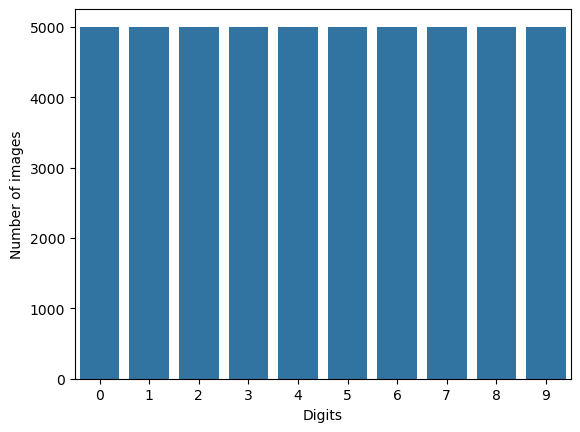

In [52]:
g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

### <a name="5"></a> 5. Normalizacja danych

In [53]:
X_train = X_train / 255.0
X_test = X_test / 255.0


y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

### <a name="6"></a> 6.Zdefiniowanie CNN

In [54]:
def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    num_conv_layers,
    filter_size,
    kernel_size,
    activation,
):
    """
    Hiperparametry:
    learning_rate: Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw gęstych (dense).
    num_dense_nodes: Liczba neuronów w każdej warstwie gęstej.
    num_conv_layers: Liczba warstw konwolucyjnych
    filter_size: Liczba filtrów w warstwach konwolucyjnych.
    kernel_size: Rozmiar kernela.
    activation: Funkcja aktywacji dla wszystkich warstw.
    """

    model = Sequential()

    
    for i in range(num_conv_layers):
        filters = filter_size + (15*i)
        model.add(Conv2D(kernel_size=kernel_size, strides=1, filters=filter_size, padding='same',
                     activation=activation))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Dropout(0.25))

    model.add(Flatten()) 

    for i in range(num_dense_layers):

        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))


    model.add(Dense(10, activation='sigmoid')) 
    
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

### <a name="7"></a> 7.Zdefiniowanie przestrzeni hiperparametrów 

In [55]:
param_grid = {
    "learning_rate": (1e-6, 1e-2),
    "num_dense_layers": (1, 5),
    "num_dense_nodes": (10, 500),
    "num_conv_layers": (2, 5),
    "filter_size": [16, 32, 64, 128],
    "kernel_size": [(3, 3), (5, 5), (7, 7)],
    "activation": ["relu", "sigmoid"]
}

### <a name="8"></a> 8.Zmienne globalne

In [56]:
# model zapisany pod nazwą
path_best_model = 'cnn_model.h5'
# punkt startowy dla optymalizacji
best_accuracy = 0
random_state = None

### <a name="9"></a> 9. Wykonanie proces optymalizacji bayesowskiej za pomocą algorytmu BOinEA:



In [57]:
class Individual():
    """Klasa reprezentująca pojedyńczego osobnika,
        przechowuje wszystkie jego cechy"""
    def __init__(self,
                 learning_rate = None,
                 num_dense_layers =None,
                 num_dense_nodes = None,
                 activation = None,
                 num_conv_layers = None,
                 filter_size = None,
                 kernel_size = None,
                 evaluate_ind=-1
                 ):
        self.learning_rate = learning_rate
        self.num_dense_layers = num_dense_layers
        self.num_dense_nodes = num_dense_nodes
        self.activation = activation
        self.num_conv_layers = num_conv_layers
        self.filter_size = filter_size
        self.kernel_size = kernel_size
        self.evaluate_ind = evaluate_ind
        super().__init__()
    def __repr__(self):
        """Reprezentacja obiektu zawierająca wszystkie jego cechy."""
        return (
            f"Individual("
            f"learning_rate={self.learning_rate}, "
            f"num_dense_layers={self.num_dense_layers}, "
            f"num_dense_nodes={self.num_dense_nodes}, "
            f"activation={self.activation}, "
            f"num_conv_layers={self.num_conv_layers}, "
            f"filter_size={self.filter_size}, "
            f"kernel_size={self.kernel_size}, "
            f"evaluate_ind={self.evaluate_ind})"
        )


In [ ]:

def mutation(individual: Individual, param_grid, p_m_con=0.3):
    """Metoda odpowiedzialna za mutacje"""

    # Pobranie wszystkich atrybutów, które nie są None
    non_none_attributes = {
        attr: value for attr, value in vars(individual).items() if value is not None
    }
    # Mutacja każdej zmiennej
    mutated_attributes = {}
    for attr, value in non_none_attributes.items():
        if attr in param_grid:  # Jeśli zmienna istnieje w param_grid
            if isinstance(param_grid[attr], tuple):  # Mutujemy tylko liczby
                mutated_attributes[attr] = mutate_variable(value, attr, param_grid, p_m_con=p_m_con)
            elif isinstance(param_grid[attr], list):  # Zmienna kategoryczna - bez mutacji
                mutated_attributes[attr] = value  # Przepisanie bez zmian
        else:
            mutated_attributes[attr] = value  # Przepisujemy wartości spoza param_grid bez zmian

    new_individual = Individual(**mutated_attributes)
    return new_individual


def mutate_variable(variable, variable_name, param_grid, length=30, p_m_con=0.3):
    """Metoda odpowiedzialna za mutację zmiennych ciągłych"""
    mutant_gene = variable
    if variable_name not in param_grid:
        raise ValueError(f"Zmienna '{variable_name}' nie istnieje w param_grid.")
    param = param_grid[variable_name]

    if isinstance(param, tuple):
        lower_bound, upper_bound = param
        # Obliczenie precyzji
        precision = (upper_bound - lower_bound) / ((2 ** length) - 1)
    else:
        raise ValueError(f"Zmienna '{variable_name}' nie jest numeryczna i nie może być mutowana.")

    #mutacja zmiennej ciągłej
    mutant_gene = encode_variable(mutant_gene,precision, lower_bound,length)
    for idx in range(len(mutant_gene)):
        if np.random.rand() < p_m_con:  # Prawdopodobieństwo mutacji
            if mutant_gene[idx] == 0:
                mutant_gene[idx] = 1
            else:
                mutant_gene[idx] = 0
    mutant_gene = decode_individual(mutant_gene, length,precision,lower_bound)
    if isinstance(variable, int):
        mutant_gene = int(round(mutant_gene))
    return mutant_gene

def encode_variable(value, precision, lower_bound, length):
    """Zakodowanie liczby do postaci bitowej"""
    shifted_value = (value - lower_bound) / precision
    int_value = int(round(shifted_value))
    binary_representation = [int(bit) for bit in bin(int_value)[2:].zfill(length)]

    return binary_representation

def decode_individual(individual, length, precision, lower_bound):
    """Dekoduje zakodowaną tablicę bitową na wartość rzeczywistą."""
    num_sum = sum(individual[-(i + 1)] * (2 ** i) for i in range(length))
    decoded_value = (num_sum * precision) + lower_bound
    return decoded_value


def crossover(parent_1: Individual, parent_2: Individual, param_grid, length=20):
    """Krzyżowanie dwóch osobników z uwzględnieniem typów cech i obliczaniem wartości `evaluate_ind`."""

    child_1_attributes = {}
    child_2_attributes = {}
    toggle = True  # Flaga do naprzemiennego przydzielania wartości cech kategorycznych

    for attr in param_grid:
        # Pomiń evaluate_ind podczas krzyżowaniu
        if attr == "evaluate_ind":
            continue

        # Pobierz wartości cechy dla obu rodziców
        value_1 = getattr(parent_1, attr)
        value_2 = getattr(parent_2, attr)

        # Jeśli cecha jest None, pomijamy ją
        if value_1 is None or value_2 is None:
            continue

        # Obsługa cech numerycznych
        if isinstance(param_grid[attr], tuple):  # Zakres wartości numerycznych
            lower_bound, upper_bound = param_grid[attr]
            precision = (upper_bound - lower_bound) / ((2 ** length) - 1)

            # Zakodowanie wartości
            binary_1 = encode_variable(value_1, precision, lower_bound, length)
            binary_2 = encode_variable(value_2, precision, lower_bound, length)

            # One-point crossover
            crossover_point = random.randint(1, length - 14)
            child_binary_1 = binary_1[:crossover_point] + binary_2[crossover_point:]
            child_binary_2 = binary_2[:crossover_point] + binary_1[crossover_point:]

            # Dekodowanie wartości
            child_value_1 = decode_individual(child_binary_1, length, precision, lower_bound)
            child_value_2 = decode_individual(child_binary_2, length, precision, lower_bound)

            # Konwersja na int dla cech takich jak num_dense_layers
            if attr in ['num_dense_layers', 'num_dense_nodes', 'num_conv_layers']:
                child_value_1 = int(round(child_value_1))
                child_value_2 = int(round(child_value_2))

            # Przypisanie wartości do atrybutów
            child_1_attributes[attr] = child_value_1
            child_2_attributes[attr] = child_value_2

        # Obsługa cech kategorycznych
        elif isinstance(param_grid[attr], list):  # Lista kategoryczna
            if toggle:
                child_1_attributes[attr] = value_1
                child_2_attributes[attr] = value_2
            else:
                child_1_attributes[attr] = value_2
                child_2_attributes[attr] = value_1
            toggle = not toggle  # Zmiana flagi dla naprzemienności

    # Tworzenie potomków bez "evaluate_ind"
    child_1 = Individual(**child_1_attributes)
    child_2 = Individual(**child_2_attributes)

    return child_1, child_2

def tournament_selection(population, tournament_size=2):

    # Wybierz pierwszego rodzica
    candidates_1 = random.sample(population, tournament_size)
    parent_1 = max(candidates_1, key=lambda individual: individual.evaluate_ind)

    # Wybierz drugiego rodzica, upewniając się, że jest różny od pierwszego
    while True:
        candidates_2 = random.sample(population, tournament_size)
        parent_2 = max(candidates_2, key=lambda individual: individual.evaluate_ind)
        if parent_2 != parent_1:
            break
    return parent_1, parent_2


def individual_to_list(individual, space):
    """
    Przekształca obiekt `Individual` na listę wartości odpowiadającą przestrzeni `space`.
    Tylko cechy zdefiniowane w `space` zostaną uwzględnione.
    """
    # Wyciągnij nazwy parametrów ze space
    space_names = [dim.name for dim in space]

    # Zmapuj parametry individual do listy zgodnej z przestrzenią space
    return [getattr(individual, name) for name in space_names]

class GeneticAlgorithm:
    def __init__(self, param_grid, iteration=9, mutation_probability=0.2, population_size = 10):
        self.iteration = iteration
        self.list_num_iter = []
        self.best_solution_iter = []
        self.solution_iter = []
        self.param_grid = param_grid
        self.mutation_probability = mutation_probability
        self.path_best_model = 'cnn_model.h5'
        self.best_accuracy = 0
        self.best_hyperparameters = None
        self.solution_iter_genotype = []
        self.population_size=population_size
    

    def objective(self, learning_rate, num_dense_layers, num_dense_nodes, num_conv_layers, filter_size, kernel_size, activation):
        """
        Funkcja celu oceniająca model.
        Hiperparametry:
        - learning_rate: Współczynnik uczenia dla optymalizatora.
        - num_dense_layers: Liczba warstw gęstych (dense).
        - num_dense_nodes: Liczba neuronów w każdej warstwie gęstej.
        - num_conv_layers: Liczba warstw konwolucyjnych.
        - filter_size: Liczba filtrów w warstwach konwolucyjnych.
        - kernel_size: Rozmiar kernela.
        - activation: Funkcja aktywacji dla wszystkich warstw.
        """
        if kernel_size == '(3,3)':
            kernel_size = (3, 3)
        elif kernel_size == '(5,5)':
            kernel_size = (5, 5)
        elif kernel_size == '(7,7)':
            kernel_size = (7, 7)

        
        print('learning rate: {0:.1e}'.format(learning_rate))
        print('num_dense_layers:', num_dense_layers)
        print('num_dense_nodes:', num_dense_nodes)
        print('num_conv_layers:', num_conv_layers)
        print('filter_size:', filter_size)
        print('kernel_size:', kernel_size)
        print('activation:', activation)
        print()

        model = create_cnn(learning_rate=learning_rate,
                           num_dense_layers=num_dense_layers,
                           num_dense_nodes=num_dense_nodes,
                           num_conv_layers=num_conv_layers,
                           filter_size=filter_size,
                           kernel_size=kernel_size,
                           activation=activation)

        
        learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                    patience=2,
                                                    verbose=1,
                                                    factor=0.5,
                                                    min_lr=0.00001)

        history = model.fit(x=X_train,
                            y=y_train,
                            epochs=5,
                            batch_size=32,
                            validation_split=0.1,
                            callbacks=[learning_rate_reduction])

        
        accuracy = history.history['val_accuracy'][-1]

        # Wypisanie dokładności
        print()
        print("Accuracy: {0:.2%}".format(accuracy))
        print()

       
        if accuracy > self.best_accuracy:
            model.save(self.path_best_model)
            self.best_accuracy = accuracy
            self.best_hyperparameters = {
                "learning_rate": learning_rate,
                "num_dense_layers": num_dense_layers,
                "num_dense_nodes": num_dense_nodes,
                "num_conv_layers": num_conv_layers,
                "filter_size": filter_size,
                "kernel_size": kernel_size,
                "activation": activation
            }

        
        del model

        
        return accuracy


    def first_generate_population(self,param_grid):
        population = []
        for _ in range(self.population_size):
            random_params = {}
            for param, values in param_grid.items():
                if isinstance(values, tuple):  # Zakres wartości liczbowych
                    random_params[param] = random.uniform(*values)
                    if isinstance(values[0], int):  # Jeśli to liczba całkowita
                        random_params[param] = int(round(random_params[param]))
                elif isinstance(values, list):  # Lista kategorii
                    random_params[param] = random.choice(values)
            individual = Individual(**random_params)
            # Oblicz `evaluate_ind` dla osobnika
            objective_args = inspect.signature(self.objective).parameters.keys()
            hyperparameters = {
                attr: value for attr, value in vars(individual).items() if attr in objective_args
            }
            individual.evaluate_ind = self.objective(**hyperparameters)
            population.append(individual)     
            self.best_solution_iter.append(self.best_accuracy)
        return population
    

    def define_search_space_around_individual(self, individual):
        search_space = [
            Real(
                low=max(1e-6, individual.learning_rate - 1e-4),
                high=min(1e-2, individual.learning_rate + 1e-4),
                prior='log-uniform',
                name='learning_rate'
            ),
            Integer(
                low=max(1, individual.num_dense_layers - 1),
                high=min(individual.num_dense_layers + 1,5),
                name='num_dense_layers'
            ),
            Integer(
                low=max(10, individual.num_dense_nodes - 20),
                high=min(individual.num_dense_nodes + 20,500),
                name='num_dense_nodes'
            )
            # Usunięto stałe punkty np.activation
        ]
        return search_space

    def point_to_individual(self, point, space, best_individual=None):
        """
        Konwertuje listępunktu optimizer.ask() na obiekt Individual.
        Dla atrybutów, których nie ma w space, używamy  wartości z best_individual.
        """
        # Nazwy parametrów, które faktycznie bierzemy z `space`
        space_names = [dim.name for dim in space]

        # Zrobienie słownika z parametrami, które *są* w space
        param_dict = dict(zip(space_names, point))

        # Jeśli mamy `best_individual`, to dopełnij brakujące parametry
        if best_individual is not None:
            all_attrs = [
                "learning_rate",
                "num_dense_layers",
                "num_dense_nodes",
                "num_conv_layers",
                "filter_size",
                "kernel_size",
                "activation",
                "evaluate_ind"
                # cokolwiek jeszcze Individual może mieć
            ]
            for attr in all_attrs:
                # jeżeli w param_dict nie ma klucza `attr`, weź go z best_individual
                if attr not in param_dict:
                    param_dict[attr] = getattr(best_individual, attr, None)
        
        return Individual(**param_dict)
        
    
    def run(self):

        # Inicjalizacja populacji
        population = self.first_generate_population(self.param_grid)

        self.solution_iter = [individual.evaluate_ind for individual in population]
        self.solution_iter_genotype = [vars(individual) for individual in population]
        self.list_num_iter = [i for i in range(1,(self.iteration+1)*self.population_size+1 + (self.iteration-1)*10)]
        print(self.list_num_iter)
        iteration = 1
        bayesian_flag = False
        for i in range(self.iteration):

            new_population = []
            # Generowanie nowej populacji
            for j in range(self.population_size//2):

                parent_1, parent_2 = tournament_selection(population)
                child_1, child_2 = crossover(parent_1, parent_2, self.param_grid)

                if random.random() <= self.mutation_probability:
                    child_1 = mutation(child_1, self.param_grid)

                # Obliczenie oceny dla child_1
                objective_args = inspect.signature(self.objective).parameters.keys()
                hyperparameters_1 = {
                    attr: value for attr, value in vars(child_1).items()
                    if attr in objective_args
                }
                child_1.evaluate_ind = self.objective(**hyperparameters_1)

                if random.random() <= self.mutation_probability:
                    child_2 = mutation(child_2, param_grid)

                # Obliczenie oceny dla child_2
                hyperparameters_2 = {
                    attr: value for attr, value in vars(child_2).items()
                    if attr in objective_args
                }
                child_2.evaluate_ind = self.objective(**hyperparameters_2)

                #aktualizacja zmiennych wewnętrznych
                #dodanie osobników do populacji i zaktualizowanie best_accuracy
                new_population.append(child_1)
                self.best_solution_iter.append(self.best_accuracy)
                new_population.append(child_2)
                self.best_solution_iter.append(self.best_accuracy)


                #dodanie accuracy dziecka do listy i dodanie hiperparametrów 
                self.solution_iter.append(child_1.evaluate_ind)
                self.solution_iter_genotype.append(vars(child_1))
                self.solution_iter.append(child_2.evaluate_ind)
                self.solution_iter_genotype.append(vars(child_2))
            population = new_population
            if bayesian_flag:
                self.best_individual = max(population, key=lambda individual: individual.evaluate_ind)

                space = self.define_search_space_around_individual(self.best_individual)
                
                random_state = None
                rng = check_random_state(random_state)
                space = normalize_dimensions(space)
                base_estimator = None
                if base_estimator is None:
                        base_estimator = cook_estimator(
                            "GP", space=space, random_state=rng.randint(0, np.iinfo(np.int32).max),
                            noise="gaussian")

                acq_optimizer_kwargs = {
                        "n_points": 10000, "n_restarts_optimizer": 5,
                        "n_jobs": 1}
                acq_func_kwargs = {"xi": 0.01, "kappa": 1.96}                

            
                optimizer = Optimizer(space, base_estimator = base_estimator,
                        n_initial_points=4,
                        initial_point_generator="random",
                        n_jobs=1,
                        acq_func="EI", acq_optimizer="lbfgs",
                        random_state=rng,
                        model_queue_size=None,
                        acq_optimizer_kwargs=acq_optimizer_kwargs,
                        acq_func_kwargs=acq_func_kwargs)




                optimizer.tell(individual_to_list(self.best_individual,space), -self.best_individual.evaluate_ind)
                bayes_candidates = []
                for n in range(10):
                    next_x = optimizer.ask()
                    # Stałe parametry z best_individual
                    static_params = [
                        self.best_individual.num_conv_layers,
                        self.best_individual.filter_size,
                        self.best_individual.kernel_size,
                        self.best_individual.activation
                    ]

                    # Konkatenacja dynamicznych i stałych parametrów
                    point_rate = next_x + static_params
                    self.best_solution_iter.append(self.best_accuracy)
                    next_y = -self.objective(*point_rate)
                    optimizer.tell(next_x, next_y)
                    next_x = self.point_to_individual(next_x,space,self.best_individual)
                    next_x.evaluate_ind = -next_y
                    self.solution_iter_genotype.append(vars(next_x))
                    self.solution_iter.append(-next_y) 
                    bayes_candidates.append(next_x)


                    if next_x.evaluate_ind > self.best_individual.evaluate_ind:
                        if next_x.evaluate_ind > self.best_accuracy:
                            self.best_accuracy = next_x.evaluate_ind
                            self.best_hyperparameters = {
                                            "learning_rate": next_x.learning_rate,
                                            "num_dense_layers": next_x.num_dense_layers,
                                            "num_dense_nodes": next_x.num_dense_nodes,
                                            "num_conv_layers": next_x.num_conv_layers,
                                            "filter_size": next_x.filter_size,
                                            "kernel_size": next_x.kernel_size,
                                            "activation": next_x.activation
                                            }

                best_bayes_candidate = max(bayes_candidates, key=lambda c: c.evaluate_ind)

                if best_bayes_candidate.evaluate_ind > self.best_individual.evaluate_ind:
                    idx = population.index(self.best_individual)
                    population[idx] = best_bayes_candidate
            bayesian_flag = True
            
            iteration += 1
        print("Najlepsze hiperparametry:", self.best_hyperparameters)
        print("Najlepsza dokładność:", self.best_accuracy)
        self.save_to_files()

    def save_to_files(self):
        """Zapisuje dane iteracji do plików CSV."""
        # Przygotowanie danych do pierwszego pliku
        solution_data = {
            "Iteration": self.list_num_iter,
            "Solutions": self.solution_iter
        }
        df_solutions = pd.DataFrame(solution_data)
        df_solutions.to_csv("solutions.csv", index=False)
        print("Zapisano plik: solutions.csv")

        genotype_data = []

        for i, genotype_dict in enumerate(
                self.solution_iter_genotype):  # Zakładamy, że self.solution_iter_genotype to lista słowników
            if isinstance(genotype_dict, dict):  # Upewnij się, że to słownik
                genotype_data.append({"Iteration": i + 1, **genotype_dict})
            else:
                print(f"Nieprawidłowy genotyp: {genotype_dict}")

        print("Wynik genotype_data:", genotype_data)

        df_genotypes = pd.DataFrame(genotype_data)
        df_genotypes.to_csv("genotypes.csv", index=False)
        print("Zapisano plik: genotypes.csv")



        # Przygotowanie danych do drugiego pliku
        best_solution_data = {
            "Iteration": self.list_num_iter,
            "Best Accuracy": self.best_solution_iter
        }
        df_best_solutions = pd.DataFrame(best_solution_data)
        df_best_solutions.to_csv("best_solutions.csv", index=False)
        print("Zapisano plik: best_solutions.csv")


if __name__ == "__main__":

    genetic_algorithm = GeneticAlgorithm(
        iteration = 9,
        param_grid = param_grid,
        mutation_probability=0.3,
        population_size=10
    )
    start_time = time.time()
    genetic_algorithm.run()
    end_time = time.time()

    execution_time = end_time - start_time
    print(f"Czas wykonania funkcji run: {execution_time:.2f} sekund")


learning rate: 5.0e-03
num_dense_layers: 2
num_dense_nodes: 91
num_conv_layers: 2
filter_size: 16
kernel_size: (5, 5)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.3896 - loss: 0.2635 - val_accuracy: 0.4724 - val_loss: 0.2314 - learning_rate: 0.0050
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5688 - loss: 0.1927 - val_accuracy: 0.5896 - val_loss: 0.1820 - learning_rate: 0.0050
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6307 - loss: 0.1691 - val_accuracy: 0.6388 - val_loss: 0.1693 - learning_rate: 0.0050
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6645 - loss: 0.1566 - val_accuracy: 0.6620 - val_loss: 0.1557 - learning_rate: 0.0050
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6877 - loss: 0.1464 - val_accuracy: 0.6714 - val_loss: 0.1539 - learning_rate: 0.0050



Accuracy: 67.14%

learning rate: 1.1e-03
num_dense_layers: 2
num_dense_nodes: 109
num_conv_layers: 4
filter_size: 128
kernel_size: (5, 5)
activation: sigmoid

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 88s 61ms/step - accuracy: 0.3154 - loss: 0.2845 - val_accuracy: 0.4516 - val_loss: 0.2293 - learning_rate: 0.0011
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 85s 61ms/step - accuracy: 0.5504 - loss: 0.1980 - val_accuracy: 0.5438 - val_loss: 0.1983 - learning_rate: 0.0011
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 86s 61ms/step - accuracy: 0.6063 - loss: 0.1769 - val_accuracy: 0.6018 - val_loss: 0.1793 - learning_rate: 0.0011
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 89s 63ms/step - accuracy: 0.6521 - loss: 0.1594 - val_accuracy: 0.2958 - val_loss: 0.3491 - learning_rate: 0.0011
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 87s 62ms/step - accuracy: 0.6738 - loss: 0.1513 - val_accuracy: 0.6296 - val_loss: 0.1652 - learning_rate: 0.0011

Accuracy: 62.96%

learning rate: 7.6e-03
num_dense_layers: 1
num


Accuracy: 70.16%

learning rate: 3.7e-03
num_dense_layers: 4
num_dense_nodes: 162
num_conv_layers: 3
filter_size: 64
kernel_size: (7, 7)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - accuracy: 0.3224 - loss: 0.2798 - val_accuracy: 0.4928 - val_loss: 0.2194 - learning_rate: 0.0037
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 44s 31ms/step - accuracy: 0.5399 - loss: 0.2036 - val_accuracy: 0.5702 - val_loss: 0.1931 - learning_rate: 0.0037
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 44s 31ms/step - accuracy: 0.6316 - loss: 0.1709 - val_accuracy: 0.5126 - val_loss: 0.2136 - learning_rate: 0.0037
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - accuracy: 0.6851 - loss: 0.1501 - val_accuracy: 0.6348 - val_loss: 0.1694 - learning_rate: 0.0037
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - accuracy: 0.7208 - loss: 0.1338 - val_accuracy: 0.6170 - val_loss: 0.1725 - learning_rate: 0.0037

Accuracy: 61.70%

learning rate: 6.8e-03
num_dense_layers: 3
num_den


Accuracy: 70.44%

learning rate: 7.3e-03
num_dense_layers: 1
num_dense_nodes: 192
num_conv_layers: 3
filter_size: 32
kernel_size: (7, 7)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.3556 - loss: 0.2791 - val_accuracy: 0.4804 - val_loss: 0.2274 - learning_rate: 0.0073
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.5539 - loss: 0.1986 - val_accuracy: 0.5998 - val_loss: 0.1815 - learning_rate: 0.0073
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.6344 - loss: 0.1692 - val_accuracy: 0.5700 - val_loss: 0.1926 - learning_rate: 0.0073
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.6715 - loss: 0.1539 - val_accuracy: 0.6668 - val_loss: 0.1556 - learning_rate: 0.0073
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.6955 - loss: 0.1445 - val_accuracy: 0.6992 - val_loss: 0.1432 - learning_rate: 0.0073

Accuracy: 69.92%

learning rate: 7.2e-03
num_dense_layers: 3
num_den


Accuracy: 70.50%

learning rate: 3.7e-03
num_dense_layers: 1
num_dense_nodes: 392
num_conv_layers: 5
filter_size: 16
kernel_size: (7, 7)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.3018 - loss: 0.2842 - val_accuracy: 0.3866 - val_loss: 0.2638 - learning_rate: 0.0037
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.4871 - loss: 0.2194 - val_accuracy: 0.5608 - val_loss: 0.1945 - learning_rate: 0.0037
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.5563 - loss: 0.1978 - val_accuracy: 0.5690 - val_loss: 0.1861 - learning_rate: 0.0037
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.5991 - loss: 0.1815 - val_accuracy: 0.6006 - val_loss: 0.1765 - learning_rate: 0.0037
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.6255 - loss: 0.1720 - val_accuracy: 0.6310 - val_loss: 0.1711 - learning_rate: 0.0037

Accuracy: 63.10%

learning rate: 5.9e-04
num_dense_layers: 4
num_den


Accuracy: 70.62%

learning rate: 5.5e-04
num_dense_layers: 3
num_dense_nodes: 453
num_conv_layers: 2
filter_size: 32
kernel_size: (7, 7)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.4139 - loss: 0.2533 - val_accuracy: 0.5792 - val_loss: 0.1901 - learning_rate: 5.4839e-04
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.6227 - loss: 0.1722 - val_accuracy: 0.5636 - val_loss: 0.1986 - learning_rate: 5.4839e-04
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.7037 - loss: 0.1384 - val_accuracy: 0.6682 - val_loss: 0.1542 - learning_rate: 5.4839e-04
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.7527 - loss: 0.1172 - val_accuracy: 0.5580 - val_loss: 0.2277 - learning_rate: 5.4839e-04
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.7963 - loss: 0.0988 - val_accuracy: 0.6862 - val_loss: 0.1525 - learning_rate: 5.4839e-04

Accuracy: 68.62%

learning rate: 3.2e-03
num_den


Accuracy: 75.44%

learning rate: 1.8e-03
num_dense_layers: 4
num_dense_nodes: 447
num_conv_layers: 3
filter_size: 32
kernel_size: (3, 3)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.4013 - loss: 0.2537 - val_accuracy: 0.5788 - val_loss: 0.1952 - learning_rate: 0.0018
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.6147 - loss: 0.1764 - val_accuracy: 0.6180 - val_loss: 0.1728 - learning_rate: 0.0018
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.6774 - loss: 0.1516 - val_accuracy: 0.7336 - val_loss: 0.1308 - learning_rate: 0.0018
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.7147 - loss: 0.1353 - val_accuracy: 0.7144 - val_loss: 0.1381 - learning_rate: 0.0018
Epoch 5/5
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7431 - loss: 0.1234
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009224066743627191.
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.7


Accuracy: 76.24%

learning rate: 1.6e-03
num_dense_layers: 1
num_dense_nodes: 98
num_conv_layers: 4
filter_size: 64
kernel_size: (3, 3)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.4185 - loss: 0.2561 - val_accuracy: 0.4984 - val_loss: 0.2334 - learning_rate: 0.0016
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.6428 - loss: 0.1645 - val_accuracy: 0.5866 - val_loss: 0.1895 - learning_rate: 0.0016
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.7047 - loss: 0.1390 - val_accuracy: 0.7116 - val_loss: 0.1415 - learning_rate: 0.0016
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.7384 - loss: 0.1242 - val_accuracy: 0.7398 - val_loss: 0.1256 - learning_rate: 0.0016
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.7672 - loss: 0.1121 - val_accuracy: 0.7258 - val_loss: 0.1313 - learning_rate: 0.0016

Accuracy: 72.58%

learning rate: 1.6e-03
num_dense_layers: 3
num_dens


Accuracy: 77.28%

learning rate: 1.7e-03
num_dense_layers: 3
num_dense_nodes: 460
num_conv_layers: 3
filter_size: 32
kernel_size: (3, 3)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.4214 - loss: 0.2476 - val_accuracy: 0.5592 - val_loss: 0.1946 - learning_rate: 0.0017
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.6300 - loss: 0.1694 - val_accuracy: 0.6180 - val_loss: 0.1728 - learning_rate: 0.0017
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step - accuracy: 0.6866 - loss: 0.1459 - val_accuracy: 0.5736 - val_loss: 0.2119 - learning_rate: 0.0017
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.7254 - loss: 0.1299 - val_accuracy: 0.6696 - val_loss: 0.1542 - learning_rate: 0.0017
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - accuracy: 0.7512 - loss: 0.1182 - val_accuracy: 0.7444 - val_loss: 0.1240 - learning_rate: 0.0017

Accuracy: 74.44%

learning rate: 1.8e-03
num_dense_layers: 3
num_den

### <a name="10"></a> 10. Wyświetlenie najlepszych hiperparametrów:

In [63]:
print(genetic_algorithm.best_hyperparameters)

{'learning_rate': 0.001833964917208812, 'num_dense_layers': 3, 'num_dense_nodes': 446, 'num_conv_layers': 3, 'filter_size': 32, 'kernel_size': (3, 3), 'activation': 'relu'}


### <a name="11"></a> 11. Czas obliczeń dla 180 obiektów

In [86]:
print(execution_time)

47273.309428453445


### <a name="12"></a> 12. Dokładność najlepszego rozwiązania

In [64]:
genetic_algorithm.best_accuracy

0.7728000283241272

### <a name="13"></a> 13. Ocena modelu na zbiorze testowym

In [65]:

model = load_model('cnn_model.h5')
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7537 - loss: 0.1196
Test Loss: 0.12014764547348022
Test Accuracy: 0.75


### <a name="14"></a> 14. Zapisanie hiperparametrów, dokładności 100 pierwszych modeli 

In [83]:
def save_to_files():
    """Zapisuje dane iteracji do plików CSV (tylko pierwsze 100 elementów)."""

    # Ustalmy stałą określającą maksymalną liczbę elementów
    MAX_ELEMENTS = 100

    # Przygotowanie danych do pierwszego pliku
    solution_data = {
        "Iteration": genetic_algorithm.list_num_iter[:MAX_ELEMENTS],  # tylko pierwsze 100
        "Solutions": genetic_algorithm.solution_iter[:MAX_ELEMENTS]   # tylko pierwsze 100
    }
    df_solutions = pd.DataFrame(solution_data)
    df_solutions.to_csv("solutions_2.csv", index=False)
    print("Zapisano plik: solutions_2.csv (z 100 pierwszymi elementami)")

    # Przygotowanie danych (tylko 100) dla genotypów
    genotype_data = []

    # Enumerate tylko do 100-nego elementu
    for i, genotype_dict in enumerate(genetic_algorithm.solution_iter_genotype[:MAX_ELEMENTS]):
        if isinstance(genotype_dict, dict):
            genotype_data.append({"Iteration": i + 1, **genotype_dict})
        else:
            print(f"Nieprawidłowy genotyp: {genotype_dict}")

    df_genotypes = pd.DataFrame(genotype_data)
    df_genotypes.to_csv("genotypes_2.csv", index=False)
    print("Zapisano plik: genotypes_2.csv (z 100 pierwszymi elementami)")

    # Przygotowanie danych do pliku z najlepszym rozwiązaniem (też można ograniczyć)
    best_solution_data = {
        "Iteration": genetic_algorithm.list_num_iter[:MAX_ELEMENTS],     # lub wedle potrzeb
        "Best Accuracy": genetic_algorithm.best_solution_iter[:MAX_ELEMENTS]
    }
    df_best_solutions = pd.DataFrame(best_solution_data)
    df_best_solutions.to_csv("best_solutions_2.csv", index=False)
    print("Zapisano plik: best_solutions_2.csv (z 100 pierwszymi elementami)")

In [85]:
save_to_files()

Zapisano plik: solutions_2.csv (z 100 pierwszymi elementami)
Zapisano plik: genotypes_2.csv (z 100 pierwszymi elementami)
Zapisano plik: best_solutions_2.csv (z 100 pierwszymi elementami)
